In [6]:
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import datetime

In [7]:
# Load all .pkl files from the specified folder
def load_data_from_pkl(folder_path):
    all_data = []
    for file in glob.glob(os.path.join(folder_path, "*.pkl")):
        df = pd.read_pickle(file)
        all_data.append(df)
    return pd.concat(all_data, ignore_index=True)

In [18]:
# Assuming folder_path is the directory where .pkl files are stored
folder_path = "data"
data = load_data_from_pkl(folder_path)
data.head()

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO
0,0,2018-04-01 00:00:31,596,3156,57.16,31,0,0,0
1,1,2018-04-01 00:02:10,4961,3412,81.51,130,0,0,0
2,2,2018-04-01 00:07:56,2,1365,146.00,476,0,0,0
3,3,2018-04-01 00:09:29,4128,8737,64.49,569,0,0,0
4,4,2018-04-01 00:10:34,927,9906,50.99,634,0,0,0


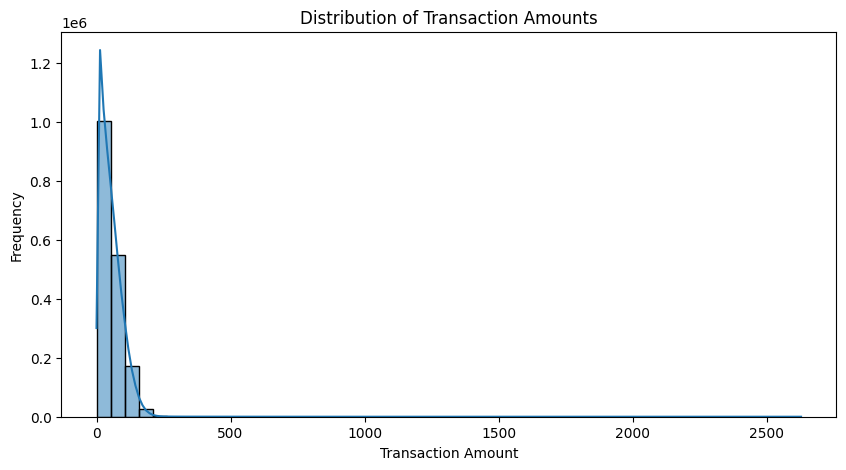

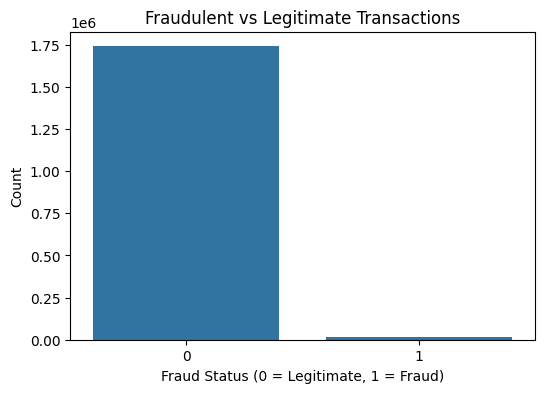

In [9]:
# Convert TX_DATETIME to datetime format
data['TX_DATETIME'] = pd.to_datetime(data['TX_DATETIME'])

# Visualization: Distribution of Transaction Amounts
plt.figure(figsize=(10, 5))
sns.histplot(data['TX_AMOUNT'], bins=50, kde=True)
plt.title("Distribution of Transaction Amounts")
plt.xlabel("Transaction Amount")
plt.ylabel("Frequency")
plt.show()

# Visualization: Fraudulent vs Legitimate Transactions
plt.figure(figsize=(6, 4))
sns.countplot(x='TX_FRAUD', data=data)
plt.title("Fraudulent vs Legitimate Transactions")
plt.xlabel("Fraud Status (0 = Legitimate, 1 = Fraud)")
plt.ylabel("Count")
plt.show()

In [10]:
# Feature Engineering
# Flagging transactions where amount > 220 as fraud (Scenario 1)
data['SCENARIO_1_FRAUD'] = data['TX_AMOUNT'] > 220

In [11]:
# Scenario 2: Marking terminals as fraud-prone for a 28-day period
def mark_scenario_2_fraud(data, num_terminals=2, period=28):
    unique_dates = data['TX_DATETIME'].dt.date.unique()
    fraud_period = datetime.timedelta(days=period)
    
    for day in unique_dates:
        selected_terminals = np.random.choice(data['TERMINAL_ID'].unique(), num_terminals, replace=False)
        day_start = pd.to_datetime(day)
        day_end = day_start + fraud_period
        data.loc[(data['TERMINAL_ID'].isin(selected_terminals)) &
                 (data['TX_DATETIME'].between(day_start, day_end)), 'SCENARIO_2_FRAUD'] = 1
    data['SCENARIO_2_FRAUD'] = data['SCENARIO_2_FRAUD'].fillna(0)

mark_scenario_2_fraud(data)

In [12]:
# Scenario 3: Marking 1/3 of selected customers' transactions as fraud with amount multiplied by 5
def mark_scenario_3_fraud(data, num_customers=3, fraction=0.33, period=14):
    unique_dates = data['TX_DATETIME'].dt.date.unique()
    fraud_period = datetime.timedelta(days=period)
    
    for day in unique_dates:
        selected_customers = np.random.choice(data['CUSTOMER_ID'].unique(), num_customers, replace=False)
        day_start = pd.to_datetime(day)
        day_end = day_start + fraud_period
        mask = (data['CUSTOMER_ID'].isin(selected_customers)) & (data['TX_DATETIME'].between(day_start, day_end))
        
        fraud_indices = data[mask].sample(frac=fraction).index
        data.loc[fraud_indices, 'TX_AMOUNT'] *= 5 # Increase amount
        data.loc[fraud_indices, 'SCENARIO_3_FRAUD'] = 1
    data['SCENARIO_3_FRAUD'] = data['SCENARIO_3_FRAUD'].fillna(0)

mark_scenario_3_fraud(data)

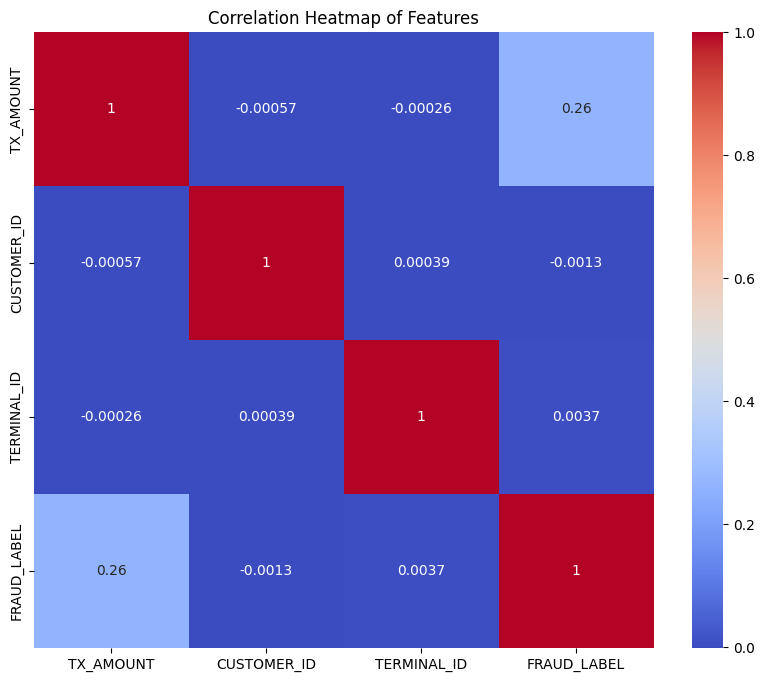

In [13]:
# Combining all scenarios into a final fraud label
data['FRAUD_LABEL'] = data[['SCENARIO_1_FRAUD', 'SCENARIO_2_FRAUD', 'SCENARIO_3_FRAUD']].any(axis=1).astype(int)

# Drop scenario columns to avoid data leakage
data.drop(['SCENARIO_1_FRAUD', 'SCENARIO_2_FRAUD', 'SCENARIO_3_FRAUD'], axis=1, inplace=True)

# Visualization: Correlation Heatmap of Features
plt.figure(figsize=(10, 8))
sns.heatmap(data[['TX_AMOUNT', 'CUSTOMER_ID', 'TERMINAL_ID', 'FRAUD_LABEL']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap of Features")
plt.show()

In [14]:
# Preparing features and target variable
X = data[['TX_AMOUNT', 'CUSTOMER_ID', 'TERMINAL_ID']]
y = data['FRAUD_LABEL']

# Scaling TX_AMOUNT
scaler = StandardScaler()
X.loc[:, 'TX_AMOUNT'] = scaler.fit_transform(X[['TX_AMOUNT']])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [15]:
# Model training
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
# Model evaluation
y_pred = model.predict(X_test)  
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9934612453847718
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00    521126
           1       0.97      0.34      0.50      5121

    accuracy                           0.99    526247
   macro avg       0.98      0.67      0.75    526247
weighted avg       0.99      0.99      0.99    526247



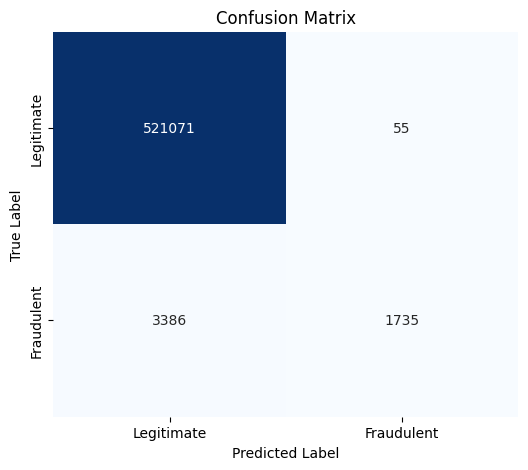

In [17]:
# Confusion Matrix Visualization
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Legitimate', 'Fraudulent'],
            yticklabels=['Legitimate', 'Fraudulent'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()